# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux_20/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]



### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
from multiprocessing import Process, Lock, Condition, Queue
from agents import Learner, Agent
import multiprocessing as mp

NOISE_EPSILON = 0.3
NO_OF_TIMES_UPDATE = 10
UPDATE_EVERY = 20
COPY_EVERY = 200
rollout_length = 5
GAMMA = 0.99
TD_EPSILON = 1e-3

In [6]:
def agent_func(ag, learner, num_episodes, max_eps_len, score_list, scores_window):
    
    t_step = 0
    t_copy = 0
    for episode in range(num_episodes):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)
        ep_len = 0
        flag = 0
        while ep_len != max_eps_len:
            
            reward = []
            for i in range(rollout_length):
                ep_len += 1
                t_step = (t_step + 1)%UPDATE_EVERY
                if(t_step == 0):
                    if len(learner.replaymem) > learner.batch_size:
                        #print("learning")
                        for i in range(NO_OF_TIMES_UPDATE): 
                            learner.learn()
                            
                states = torch.tensor(states).float()
                act = ag.ret_act(states)
                #print(act.shape)
                noise = torch.from_numpy(NOISE_EPSILON*np.random.randn(num_agents, action_size)).float()
                act = act + noise
                #print(act.shape)
                if i == 0:
                    st_in = states
                    actions = act
                    q_predict = ag.critic_network(states, actions).detach().numpy()
                
                act_toenv = act.detach().numpy() 
                env_info = env.step(act_toenv)[brain_name]
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                scores += rewards
                dones = env_info.local_done
                reward.append(rewards)
                states = next_states
                if(np.any(dones)):
                    for _ in range(rollout_length-1-i):
                        reward.append(0)
                        next_states = 0
                    flag = 1
                    break

            reward = np.transpose(np.array(reward))
            disc = 1
            g = []
            for _ in range(rollout_length):
                g.append(disc)
                disc *= GAMMA

            g = np.array(g)

            disc_reward = g*reward          # discounted reward
            
            dones = np.array(dones)
            next_states = torch.tensor(next_states).float()
            action_finalst = ag.ret_act(next_states)
            temp = ag.ret_qval(next_states, action_finalst).detach().numpy()
            #rint(temp.shape)
            #print(dones.shape)
            #print(disc_reward.shape)
            q_finalst = (1-dones)*temp
            
            #print(q_finalst.shape)
            y_val = np.transpose(np.sum(disc_reward, axis = 1) + disc*GAMMA*q_finalst)  # target value
            #print(y_val.shape)
            td_error = np.abs(y_val - q_predict) + TD_EPSILON

            for i in range(num_agents):
                priority = np.sum(td_error[i])
                st_init = st_in[i]
                st_final = next_states[i]
                action = actions[i]
                done = dones[i]
                r = reward[i]
                exp = (st_init, st_final, action, done, r)
                learner.replaymem.add(priority, exp)

            t_copy = (t_copy + 1)%COPY_EVERY
            
            if(t_copy == 0):
                for actor_param, learner_param in zip(ag.actor_network.parameters(), learner.actor_network.parameters()):
                    actor_param.data.copy_(learner_param.data)
            
                for actor_param, learner_param in zip(ag.critic_network.parameters(), learner.critic_network.parameters()):
                    actor_param.data.copy_(learner_param.data)
            
            if flag == 1:
                break
                
        score_list.append(np.mean(scores))
        scores_window.append(np.mean(scores))
        
        if episode % 100 == 0:
            torch.save(ag.actor_network.state_dict(), 'agent_actor.pth')
            torch.save(ag.critic_network.state_dict(), 'agent_critic.pth')
            torch.save(learner.actor_network.state_dict(), 'learner_actor.pth')
            torch.save(learner.critic_network.state_dict(), 'learner_critic.pth')
        if episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(episode, np.mean(scores_window)))
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(episode-100, np.mean(scores_window)))
            torch.save(ag.actor_network.state_dict(), 'agent_actor.pth')
            torch.save(ag.critic_network.state_dict(), 'agent_critic.pth')
            torch.save(learner.actor_network.state_dict(), 'learner_actor.pth')
            torch.save(learner.critic_network.state_dict(), 'learner_critic.pth')
            
            break

            
        

In [7]:
# def learner_func(learner, mem, scores_window, q1, q2, q3):
#     while True:
#         cv.acquire()
#         cv.wait()
#         cv.release()
#         print("recieve")
        
#         if(not q1.empty()):
#             mem = q1.get()
#         print(len(mem))
#         if len(mem) > learner.batch_size:
#             for i in range(NO_OF_TIMES_UPDATE): 
#                 print("learning")
#                 learner.replaymem = mem
#                 learner.learn(lock)
                
#         q1.put(learner.replaymem)
#         q2.put(learner)
#         if(not q3.empty()):
#             scores_window = q3.get()
#         if np.mean(scores_window) >= 30.0:
#             break
            
        

In [8]:
def train(num_episodes, max_eps_len, score_list, seed=12345):
    
    ag = Agent(state_size, action_size, seed)
    
    learner = Learner(state_size, action_size, seed)
    learner.actor_network.load_state_dict(torch.load('learner_actor.pth'))
    learner.critic_network.load_state_dict(torch.load('learner_critic.pth'))
    for actor_param, learner_param in zip(ag.actor_network.parameters(), learner.actor_network.parameters()):
                    actor_param.data.copy_(learner_param.data)
            
    for actor_param, learner_param in zip(ag.critic_network.parameters(), learner.critic_network.parameters()):
                    actor_param.data.copy_(learner_param.data)
    
    scores_window = deque(maxlen = 100)
    
    agent_func(ag, learner, num_episodes, max_eps_len, score_list, scores_window)
    
    
#     p1 = Process(target=learner_func, args=(learner, scores_window, ))
#     p2 = Process(target=agent_func, args=(ag, learner, num_episodes, max_eps_len, score_list, scores_window,))
    
#     p1.start()
#     p2.start()
    
#     p1.join()
#     p2.join()
    
    
    
    
    

In [ ]:
# lock = Lock()
score_list = []
train(10000, 1000, score_list)


/home/vishal/Documents/DeepRL_Continuous_Control/agents.py:109: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_network.parameters(), 1)  # gradient clipping


Episode 0	Average Score: 11.5460
Episode 10	Average Score: 8.0984
Episode 20	Average Score: 9.2373
Episode 30	Average Score: 10.7715
Episode 40	Average Score: 11.9935
Episode 50	Average Score: 13.3667
Episode 60	Average Score: 13.9270
Episode 70	Average Score: 14.9821
Episode 80	Average Score: 15.7692
Episode 90	Average Score: 16.3148


In [15]:
len(score_list)

0

In [10]:
np.save('scores1.npy', np.array(score_list))

In [ ]:
# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

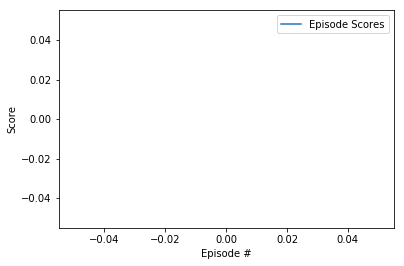

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(score_list)
ax.legend(['Episode Scores'])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```